In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
from matplotlib.colors import LogNorm

# import boost_histogram as bh
# import pickle as pl

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf

Load background data from the run of interest

In [2]:
bkg_dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
# bkg_run = 'run==180 and skip==False'
bkg_run = 'run==57 and skip==False'
# bkg_run = 'run==34 and skip==False'
bkg_dg.fileDB.query(bkg_run, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(bkg_dg.fileDB[view_cols])

    runtype  run  cycle     startTime    runtime  threshold
789     bkg   57    791  1.601937e+09  29.994622       16.0
790     bkg   57    792  1.601939e+09  29.985009       16.0
791     bkg   57    793  1.601940e+09  29.975523       16.0
792     bkg   57    794  1.601942e+09  29.997125       16.0
793     bkg   57    795  1.601944e+09  29.972125       16.0
794     bkg   57    796  1.601946e+09  29.978900       16.0
795     bkg   57    797  1.601948e+09  29.985367       16.0
796     bkg   57    798  1.601949e+09  29.991918       16.0
797     bkg   57    799  1.601951e+09  29.982529       16.0
798     bkg   57    800  1.601953e+09  29.990210       16.0
799     bkg   57    801  1.601955e+09  29.991722       16.0
800     bkg   57    802  1.601957e+09  29.969845       16.0
801     bkg   57    803  1.601958e+09  29.994022       16.0
802     bkg   57    804  1.601960e+09  30.001032       16.0
803     bkg   57    805  1.601962e+09  29.989753       16.0
804     bkg   57    806  1.601964e+09  2

In [3]:
user = True
# hit = False
hit = True

Load alpha data from the run of interest

In [4]:
alpha_dg = DataGroup('$CAGE_SW/processing/cage.json', load=True)
alpha_run = 'run==64 and skip==False'
# alpha_run = 'run==143 and skip==False'
# alpha_run = "run>50 and runtype=='alp'"
# alpha_run = 'run==50 and skip==False'
alpha_dg.fileDB.query(alpha_run, inplace=True)
view_cols = ['runtype', 'run', 'cycle', 'startTime', 'runtime', 'threshold']
print(alpha_dg.fileDB[view_cols])

    runtype  run  cycle     startTime    runtime  threshold
867     alp   64    869  1.602171e+09  29.984760       16.0
868     alp   64    870  1.602172e+09  29.996250       16.0
869     alp   64    871  1.602174e+09  29.986685       16.0
870     alp   64    872  1.602176e+09  29.993093       16.0
871     alp   64    873  1.602178e+09  29.998897       16.0
872     alp   64    874  1.602180e+09  29.971984       16.0
873     alp   64    875  1.602181e+09  29.995355       16.0
874     alp   64    876  1.602183e+09  29.998476       16.0
875     alp   64    877  1.602185e+09  29.976009       16.0
876     alp   64    878  1.602187e+09  29.997642       16.0


Plot raw energy histogram of the background data, then alpha data, from DSP files
First get dsp data, runtimes so we can normalize by time

First get file list and load background energy data (numpy array)

In [5]:
# get file list and load background energy data

lh5_dir = bkg_dg.lh5_user_dir if user else bkg_dg.lh5_dir

# if hit files
if hit == True:
    bkg_file_list = lh5_dir + bkg_dg.fileDB['hit_path'] + '/' + bkg_dg.fileDB['hit_file']
    bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max', 'ts_sec', 'timestamp', 'ts_glo'], 'ORSIS3302DecoderForEnergy/hit')
    # bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig'], 'ORSIS3302DecoderForEnergy/hit')
    
else:
    bkg_file_list = lh5_dir + bkg_dg.fileDB['dsp_path'] + '/' + bkg_dg.fileDB['dsp_file']
    bkg_df = lh5.load_dfs(bkg_file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max', 'timestamp'], 'ORSIS3302DecoderForEnergy/dsp')
    
print(bkg_file_list)

bkg_rt_min = bkg_dg.fileDB['runtime'].sum()
bkg_u_start = bkg_dg.fileDB.iloc[0]['startTime']
bkg_t_start = pd.to_datetime(bkg_u_start, unit='s') # str
print(f'Background Runtime: {bkg_rt_min} minutes')

loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc791_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc792_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc793_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc794_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc795_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc796_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc797_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc798_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc799_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc800_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run57_cyc801_hit.lh5 /global/project/projectdirs/legend/users/gothman

Get file list for alpha data

In [6]:
# get file list and load alpha data 

lh5_dir = alpha_dg.lh5_user_dir if user else alpha_dg.lh5_dir

# if hit files
if hit == True:
    alpha_file_list = lh5_dir + alpha_dg.fileDB['hit_path'] + '/' + alpha_dg.fileDB['hit_file']
    alpha_df = lh5.load_dfs(alpha_file_list, ['energy', 'trapEmax', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max', 'ts_sec', 'timestamp', 'ts_glo'], 'ORSIS3302DecoderForEnergy/hit')
    # alpha_df = lh5.load_dfs(alpha_file_list, ['energy', 'trapEftp', 'trapEftp_cal', 'bl','bl_sig'], 'ORSIS3302DecoderForEnergy/hit')
    
else:
    alpha_file_list = lh5_dir + alpha_dg.fileDB['dsp_path'] + '/' + alpha_dg.fileDB['dsp_file']
    alpha_df = lh5.load_dfs(alpha_file_list, ['energy', 'trapEmax', 'trapEftp', 'bl','bl_sig', 'bl_slope', 'lf_max', 'A_10','AoE', 'dcr', 'tp_0', 'tp_10', 'tp_90', 'tp_50', 'tp_80', 'tp_max', 'timestamp'], 'ORSIS3302DecoderForEnergy/dsp')
    
print(alpha_file_list)

alpha_rt_min = alpha_dg.fileDB['runtime'].sum()
alpha_u_start = alpha_dg.fileDB.iloc[0]['startTime']
alpha_t_start = pd.to_datetime(alpha_u_start, unit='s') # str
print(f'Alpha Runtime: {alpha_rt_min} minutes')

loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc869_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc870_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc871_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc872_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc873_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc874_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc875_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc876_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc877_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc878_hit.lh5
867    /global/project/projectdirs/legend/users/gothm...
868    /global/project/projectdirs/legend/users/gothm...
869    /global/proj

Make a baseline cut

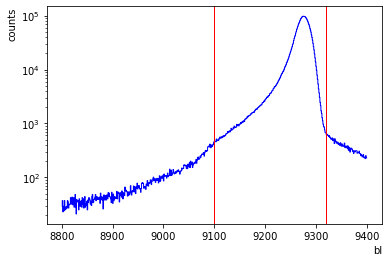

In [7]:
# blo, bhi, bpb = 9500, 10000, 1
blo, bhi, bpb = 8800, 9400, 1 #run 60
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(bkg_df['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

# bl_cut_lo, bl_cut_hi = 9700,9760
bl_cut_lo, bl_cut_hi = 9100,9320 #run 60

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

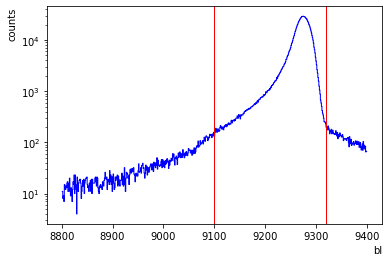

In [8]:
# blo, bhi, bpb = 9500, 10000, 1
blo, bhi, bpb = 8800, 9400, 1 #run 60
nbx = int((bhi-blo)/bpb)

bl_hist, bins = np.histogram(alpha_df['bl'], bins=nbx,
                range=[blo, bhi])

plt.semilogy(bins[1:], bl_hist, ds='steps', c='b', lw=1)

# bl_cut_lo, bl_cut_hi = 9700,9760
bl_cut_lo, bl_cut_hi = 9100,9320 #run 60

plt.axvline(bl_cut_lo, c='r', lw=1)
plt.axvline(bl_cut_hi, c='r', lw=1)

plt.xlabel('bl', ha='right', x=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()

In [9]:
# BL and energy Cut

bkg_df_cut = bkg_df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >10 and trapEftp_cal <6000').copy()
alpha_df_cut = alpha_df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi} and trapEftp_cal >10 and trapEftp_cal <6000').copy()

# bkg_df_cut = bkg_df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()
# alpha_df_cut = alpha_df.query(f'bl > {bl_cut_lo} and bl < {bl_cut_hi}').copy()

Create background histogram

In [10]:
# Create background histogram, normalized by runtime
# elo, ehi, epb = 0, 25000, 10 
elo, ehi, epb = 0, 6000, 20
etype = 'trapEftp_cal'

bkg_ene_cal = bkg_df_cut[etype]
bkg_hist, bins, _ = pgh.get_hist(bkg_ene_cal, range=(elo, ehi), dx=epb)

# normalize by runtime in seconds
bkg_hist_rt = np.divide(bkg_hist, (bkg_rt_min))

Create alpha histogram

In [11]:
# Create alpha histogram, normalized by runtime
etype = 'trapEftp_cal'
# elo, ehi, epb = 0, 25000, 10
elo, ehi, epb = 0, 6000, 20

alpha_ene_cal = alpha_df_cut[etype]
alpha_hist, bins, _ = pgh.get_hist(alpha_ene_cal, range=(elo, ehi), dx=epb)

# normalize by runtime in seconds
alpha_hist_rt = np.divide(alpha_hist, (alpha_rt_min))

Plot background spectrum

In [12]:
plt.rcParams['figure.figsize'] = [14, 10]

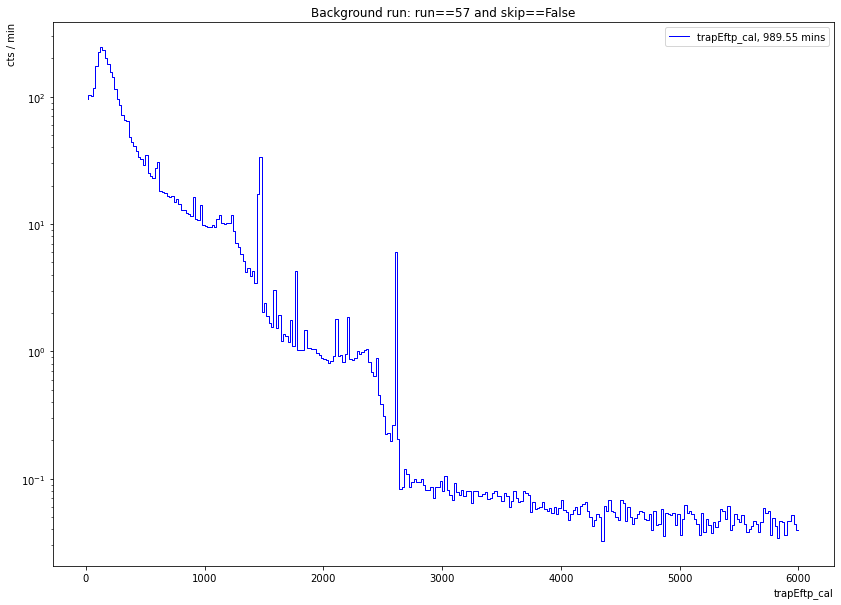

In [13]:
# Plot the histograms
plt.semilogy(bins[1:], bkg_hist_rt, ds='steps', c='b', lw=1,
            label=f'{etype}, {bkg_rt_min:.2f} mins')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / min', ha='right', y=1)
# plt.ylim(0.003,50)
plt.legend()
plt.title(f'Background run: {bkg_run}')
plt.show()

Plot alpha spectrum

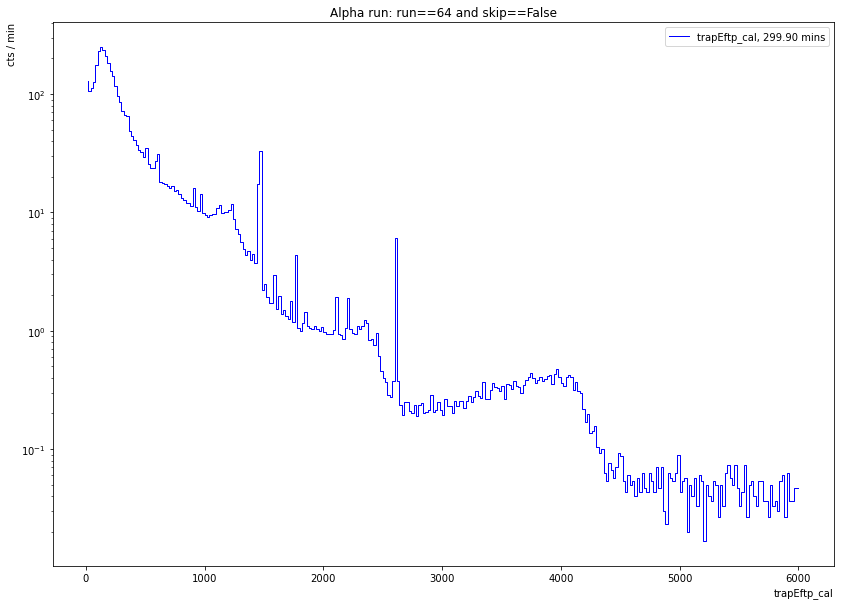

In [14]:
# Plot the alpha histogram
plt.semilogy(bins[1:], alpha_hist_rt, ds='steps', c='b', lw=1,
            label=f'{etype}, {alpha_rt_min:.2f} mins')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / min', ha='right', y=1)
# plt.ylim(0.003,50)
# plt.xlim(100, 360)
plt.legend()
plt.title(f'Alpha run: {alpha_run}')
plt.show()

Subtract the Background histogram from the alpha histogram

In [15]:
hist_bkg_sub = alpha_hist_rt - bkg_hist_rt

Plot background-subtracted histogram 

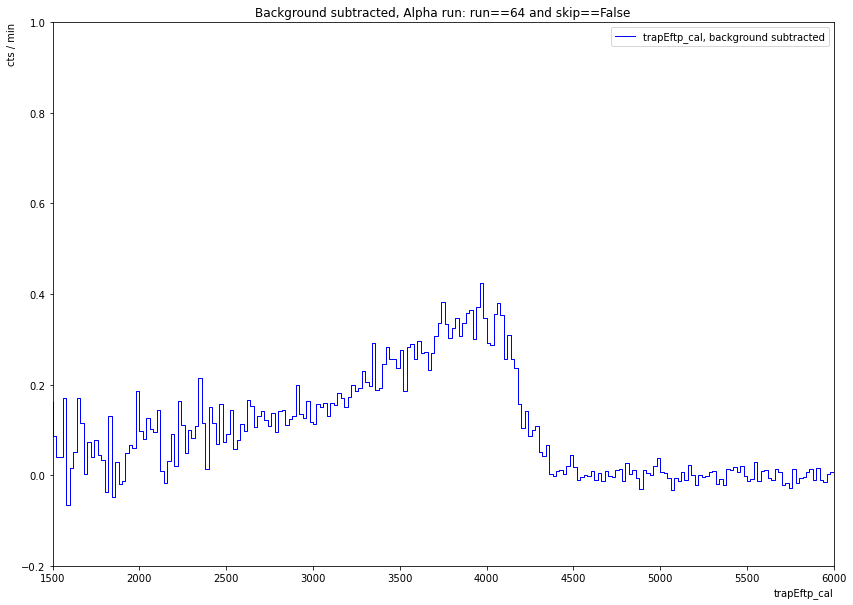

In [16]:
# Plot the background-subtracted histogram
plt.plot(bins[1:], hist_bkg_sub, ds='steps', c='b', lw=1,
            label=f'{etype}, background subtracted')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / min', ha='right', y=1)
plt.ylim(-0.2, 1)
plt.xlim(1500, 6000)
plt.legend()
plt.title(f'Background subtracted, Alpha run: {alpha_run}')
plt.show()

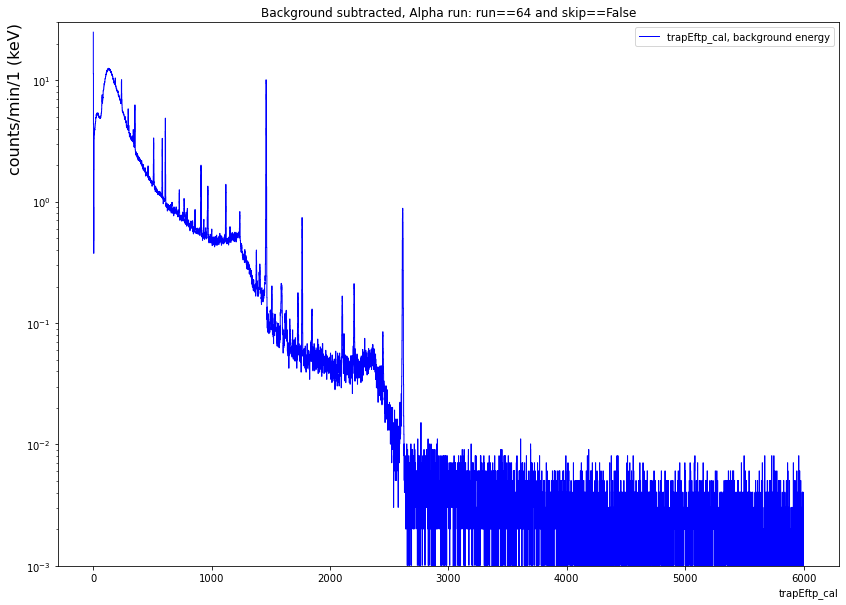

In [17]:
elo, ehi, epb = 0, 6000, 1
nbx = int((ehi-elo)/epb)
e_unit = ' (keV)'

etype = 'trapEftp_cal'

bkg_ene_hist, bins = np.histogram(bkg_df_cut[etype], bins=nbx, range=([elo, ehi]))
bkg_ene_hist_norm = np.divide(bkg_ene_hist, (bkg_rt_min))

# print(bins)

plt.semilogy(bins[1:], bkg_ene_hist_norm, ds='steps', c='b', lw=1,
            label=f'{etype}, background energy')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / min', ha='right', y=1)
plt.ylabel(f'counts/min/{str(epb)}{e_unit}', fontsize=16)
# plt.xlim(2610, 2620)
plt.ylim(0.001, 30)
plt.legend()
plt.title(f'Background subtracted, Alpha run: {alpha_run}')
plt.show()

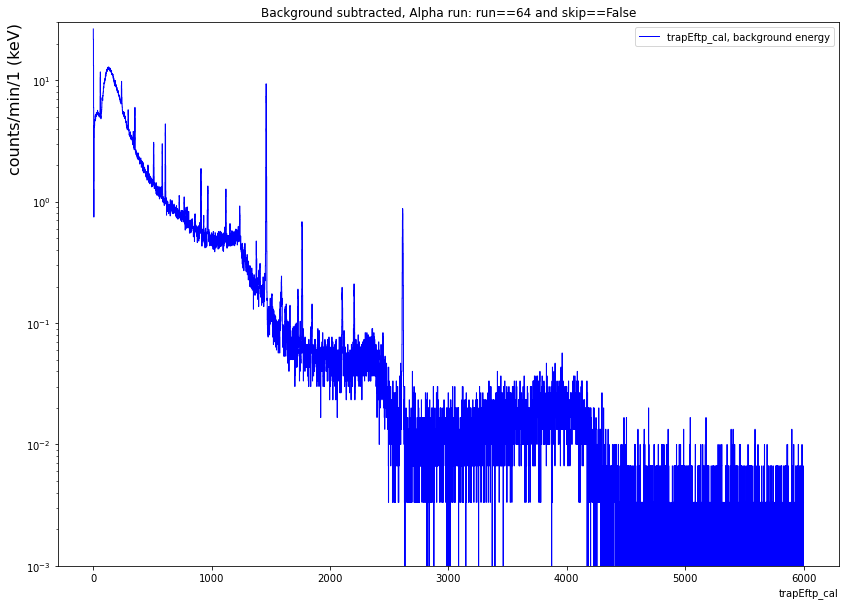

In [18]:
elo, ehi, epb = 0, 6000, 1
nbx = int((ehi-elo)/epb)
e_unit = ' (keV)'

etype = 'trapEftp_cal'

alp_ene_hist, bins = np.histogram(alpha_df_cut[etype], bins=nbx, range=([elo, ehi]))
alp_ene_hist_norm = np.divide(alp_ene_hist, (alpha_rt_min))

# print(bins)

plt.semilogy(bins[1:], alp_ene_hist_norm, ds='steps', c='b', lw=1,
            label=f'{etype}, background energy')

plt.xlabel(etype, ha='right', x=1)
plt.ylabel('cts / min', ha='right', y=1)
plt.ylabel(f'counts/min/{str(epb)}{e_unit}', fontsize=16)
# plt.xlim(2610, 2620)
plt.ylim(0.001, 30)
plt.legend()
plt.title(f'Background subtracted, Alpha run: {alpha_run}')
plt.show()

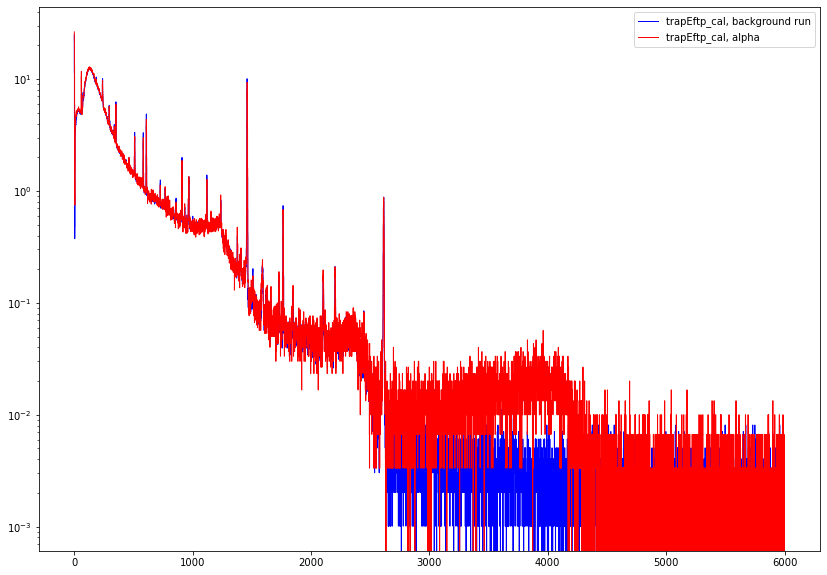

In [19]:
plt.semilogy(bins[1:], bkg_ene_hist_norm, ds='steps', c='b', lw=1,
            label=f'{etype}, background run')

plt.semilogy(bins[1:], alp_ene_hist_norm, ds='steps', c='r', lw=1,
            label=f'{etype}, alpha')
plt.legend()

plt.show()

In [20]:
print(bkg_rt_min)
print(np.amax(bkg_df_cut['lf_max']))
print(np.amin(bkg_df_cut['lf_max']))

# print(np.amax(bkg_df_cut['ts_sec']))

print(np.amax(bkg_df_cut['timestamp']))

print(len(bkg_df_cut['timestamp']))

989.5502126508327
368051.09375
149.4018096923828
180006190434
3510060


In [21]:
bkg_df_cut['ts_corr'] = bkg_df_cut['ts_glo'] - bkg_df_cut['ts_glo'][0]

print(np.amax(bkg_df_cut['ts_corr']))

59418.44279193878


<ipython-input-22-0652aecbae1d>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, Y, bkg_lfmax_hist, norm=LogNorm()) #, norm=LogNorm(0.002, 0.2)


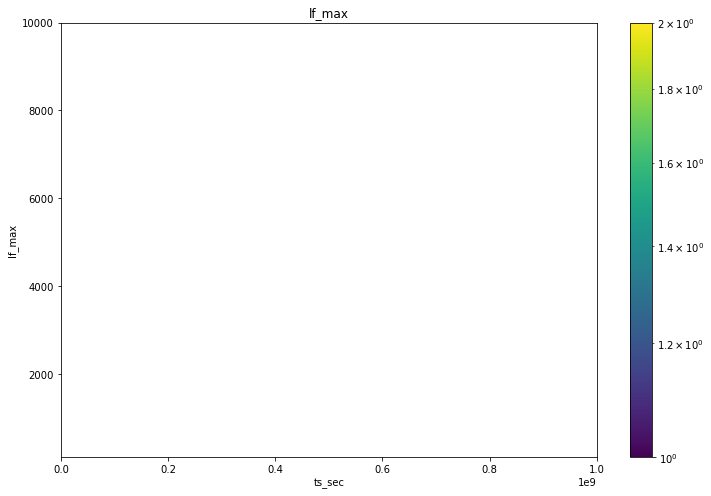

In [22]:
# #t Histogram

# tlo, thi, tpb = 0.0, 1000000000, 10000
# # tlo, thi, tpb = 0.0, 4.1e9, 1000
# # elo, ehi, epb = 0, 10000, 10
# # elo, ehi, epb = 0, 3000, 10
# flo, fhi, fpb = 100, 1e4, 10
        

# nbx = int((thi-tlo)/tpb)
# nby = int((fhi-flo)/fpb)

# bkg_lfmax_hist, xedges, yedges = np.histogram2d(bkg_df_cut['timestamp'], bkg_df_cut['lf_max'], bins=[nbx, nby], range=([tlo, thi], [flo, fhi]))

# X, Y = np.mgrid[tlo:thi:nbx*1j, flo:fhi:nby*1j]

# # bkg_aoe_hist_norm = np.divide(bkg_aoe_hist, (bkg_rt_min))

# fig = plt.figure(figsize=(12, 8))

# pcm1 = plt.pcolormesh(X, Y, bkg_lfmax_hist, norm=LogNorm()) #, norm=LogNorm(0.002, 0.2)

# plt.xlabel(f'ts_sec')
# plt.ylabel('lf_max')
# plt.title(f'lf_max')

# CB = plt.colorbar(pcm1)
# # CB.set_label('Counts/min')

# plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


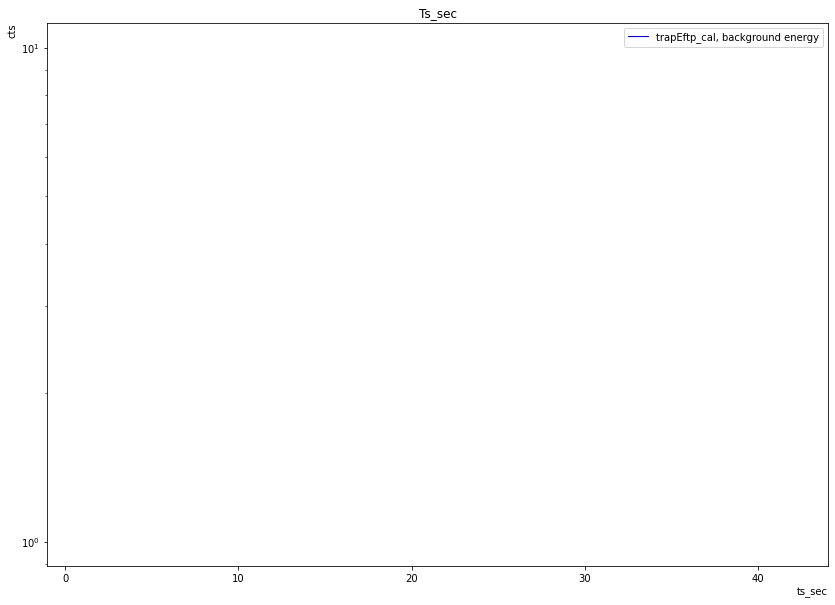

In [23]:
# tlo, thi, tpb = 0.0, 42, 1
# nbx = int((thi-tlo)/tpb)
# e_unit = ' (keV)'



# bkg_ts_hist, bins = np.histogram(bkg_df_cut['timestamp'], bins=nbx, range=([tlo, thi]))


# # print(bins)

# plt.semilogy(bins[1:], bkg_ts_hist, ds='steps', c='b', lw=1,
#             label=f'{etype}, background energy')

# plt.xlabel('ts_sec', ha='right', x=1)
# plt.ylabel('cts', ha='right', y=1)
# # plt.ylabel(f'counts/min/{str(epb)}{e_unit}', fontsize=16)
# # plt.xlim(2610, 2620)
# # plt.ylim(0.001, 30)
# plt.legend()
# plt.title(f'Ts_sec')
# plt.show()

1800.06190434


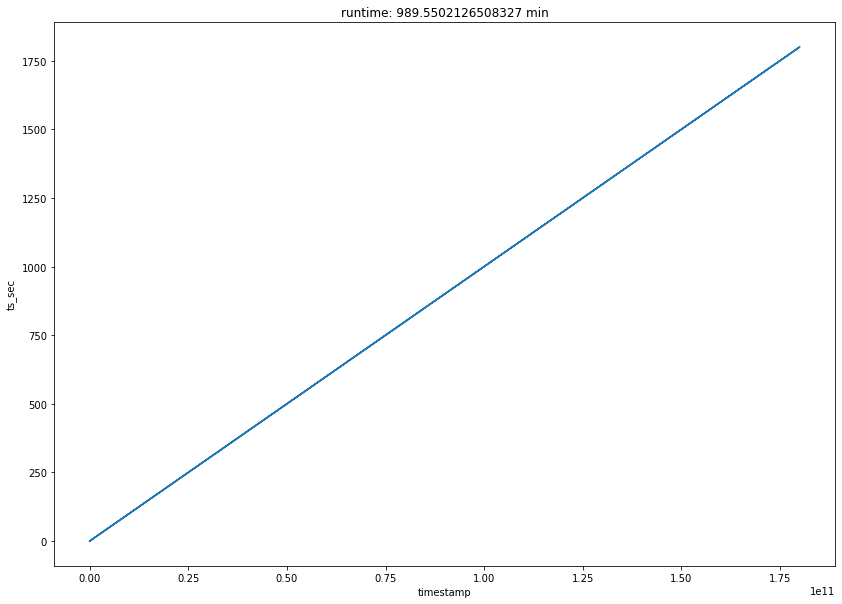

In [24]:
# plt.plot(bkg_df_cut['timestamp'], bkg_df_cut['ts_sec'])

# plt.title(f'runtime: {bkg_rt_min} min')
# plt.xlabel('timestamp')
# plt.ylabel('ts_sec')

# print(np.amax(bkg_df_cut['ts_sec']))

Use BL cut from above, create A/E

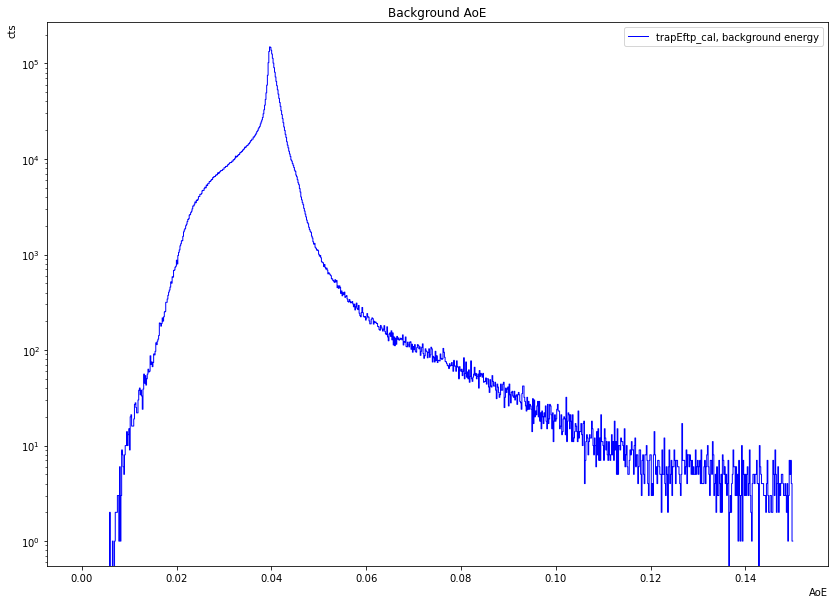

In [25]:
alo, ahi, apb = 0.0, 0.15, 0.00015
nbx = int((ahi-alo)/apb)
e_unit = ' (keV)'



bkg_1daoe_hist, bins = np.histogram(bkg_df_cut['AoE'], bins=nbx, range=([alo, ahi]))
bkg_1daoe_norm = np.divide(bkg_1daoe_hist, (bkg_rt_min))

# print(bins)

plt.semilogy(bins[1:], bkg_1daoe_hist, ds='steps', c='b', lw=1,
            label=f'{etype}, background energy')

plt.xlabel('AoE', ha='right', x=1)
plt.ylabel('cts', ha='right', y=1)
# plt.ylabel(f'counts/min/{str(epb)}{e_unit}', fontsize=16)
# plt.xlim(2610, 2620)
# plt.ylim(0.001, 30)
plt.legend()
plt.title(f'Background AoE')
plt.show()

In [26]:
# Background A_10/trapEmax vs trapEmax (A/E vs E)
import scipy
from scipy import stats
# add new A/E column
# bkg_df_cut['AoE_cal'] = bkg_df_cut['A_10'] / bkg_df_cut['trapEftp_cal']

mode_bg, counts = scipy.stats.mode(bkg_1daoe_hist)
print(mode_bg)

[0]


In [27]:
# Background A_10/trapEmax vs trapEmax (A/E vs E)
import scipy
from scipy import stats
# add new A/E column
# bkg_df_cut['AoE_cal'] = bkg_df_cut['A_10'] / bkg_df_cut['trapEftp_cal']

mode_bg, counts= scipy.stats.mode(np.array(bkg_df_cut['AoE']))
print(mode_bg)

np.mean(bkg_1daoe_hist)
# bkg_df_cut['AoE_cal'] = np.divide(bkg_df_cut['A_10'], bkg_df_cut['trapEftp_cal'])

# # add new A/E column
# alpha_df_cut['AoE_cal'] = alpha_df_cut['A_10'] / alpha_df_cut['trapEftp_cal']

[0.03960407]


3449.368

<ipython-input-69-402b7355f3c9>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, Y, bkg_aoe_hist_norm, norm=LogNorm(0.002, 0.2))


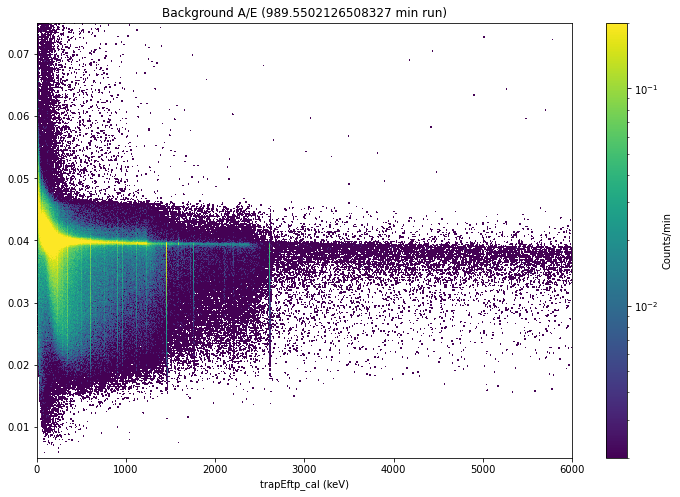

In [69]:
#A/E Histogram
alo, ahi, apb= 0.005, 0.075, 0.0001
# alo, ahi, apb = 0.0, 0.08, 0.00015 #dsp_id = 02
# alo, ahi, apb = 0.0, 0.15, 0.00015 
# elo, ehi, epb = 0, 10000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 5
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

bkg_aoe_hist, xedges, yedges = np.histogram2d(bkg_df_cut[etype], bkg_df_cut['AoE'], bins=[nbx, nby], range=([elo, ehi], [alo, ahi]))

X, Y = np.mgrid[elo:ehi:nbx*1j, alo:ahi:nby*1j]

bkg_aoe_hist_norm = np.divide(bkg_aoe_hist, (bkg_rt_min))

fig = plt.figure(figsize=(12, 8))

pcm1 = plt.pcolormesh(X, Y, bkg_aoe_hist_norm, norm=LogNorm(0.002, 0.2))

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background A/E ({bkg_rt_min} min run)')

CB = plt.colorbar(pcm1)
CB.set_label('Counts/min')

plt.show()


<ipython-input-51-13611c8c4b9b>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, alpha_aoe_hist_norm, norm=LogNorm(0.002, 0.2))


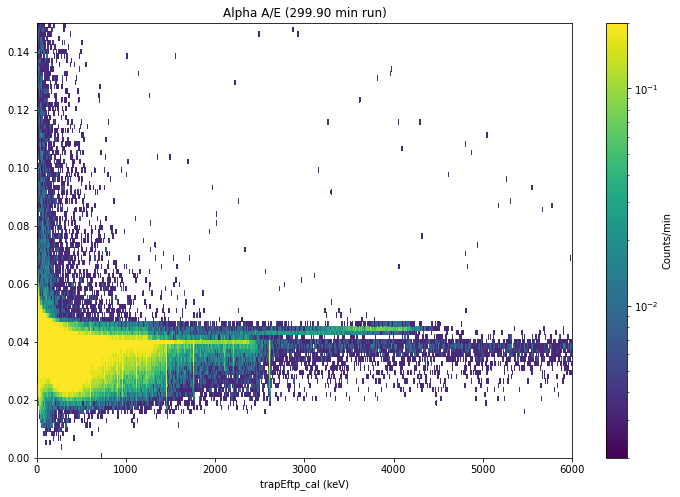

In [51]:
#A/E Histogram

alo, ahi, apb = 0.0, 0.15, 0.00015 #0.00015
# elo, ehi, epb = 0, 10000, 10
# elo, ehi, epb = 0, 3000, 10
elo, ehi, epb = 0, 6000, 5
        

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

alpha_aoe_hist, xedges, yedges = np.histogram2d(alpha_df_cut[etype], alpha_df_cut['AoE'], bins=[nbx, nby], range=([elo, ehi], [alo, ahi]))

X, Y = np.mgrid[elo:ehi:nbx*1j, alo:ahi:nby*1j]

alpha_aoe_hist_norm = np.divide(alpha_aoe_hist, (alpha_rt_min))

fig = plt.figure(figsize=(12, 8))

pcm = plt.pcolormesh(X, Y, alpha_aoe_hist_norm, norm=LogNorm(0.002, 0.2))

plt.xlabel(f'{etype} (keV)')
plt.title(f'Alpha A/E ({alpha_rt_min:.2f} min run)')

CB = plt.colorbar(pcm)
CB.set_label('Counts/min')


plt.show()

In [52]:
aoe_backgroundSub = bkg_aoe_hist_norm - alpha_aoe_hist_norm
aoe_backgroundSub_1 = alpha_aoe_hist_norm - bkg_aoe_hist_norm
print(np.sum(aoe_backgroundSub))
print(np.sum(alpha_aoe_hist_norm))
print(np.sum(bkg_aoe_hist_norm))

-80.98024382452878
3521.850607420155
3440.8703635956263


<ipython-input-53-64ac755f7804>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, Y, aoe_backgroundSub)


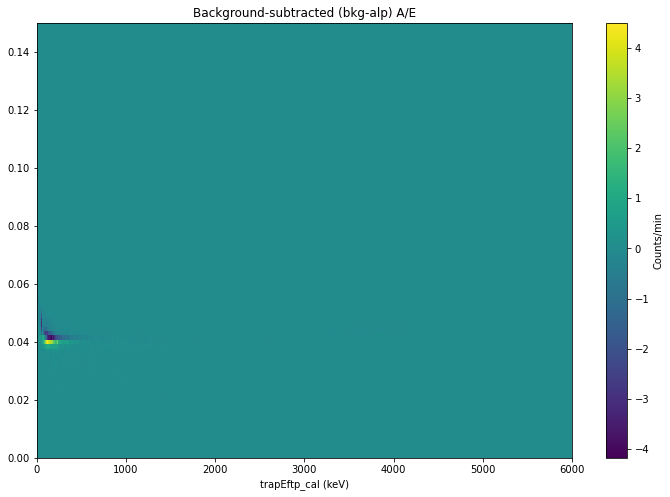

In [53]:
fig = plt.figure(figsize=(12, 8))

pcm2 = plt.pcolormesh(X, Y, aoe_backgroundSub)

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background-subtracted (bkg-alp) A/E')


CB = plt.colorbar(pcm2)
CB.set_label('Counts/min')

plt.show()

<ipython-input-54-0c55a2719bee>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, Y, aoe_backgroundSub_1) #, norm=LogNorm(0.002, 0.2)


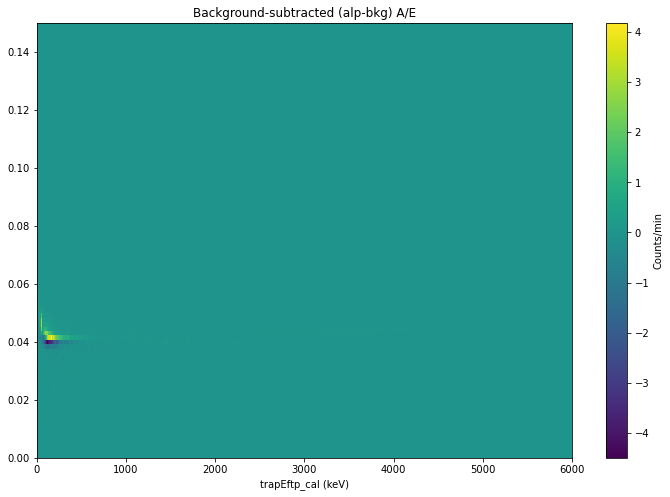

In [54]:
fig = plt.figure(figsize=(12, 8))

pcm2 = plt.pcolormesh(X, Y, aoe_backgroundSub_1) #, norm=LogNorm(0.002, 0.2)

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background-subtracted (alp-bkg) A/E')


CB = plt.colorbar(pcm2)
CB.set_label('Counts/min')

plt.show()

DCR

In [33]:
# #creat new DCR
# const = -0.0015
# const2 = -0.0000015
# # const2 = -0.0000000000003
# bkg_df_cut['dcr_new'] = bkg_df_cut['dcr'] + const*(bkg_df_cut['trapEftp_cal']) + const2*(bkg_df_cut['trapEftp_cal'])**2

# alpha_df_cut['dcr_new'] = alpha_df_cut['dcr'] + const*(alpha_df_cut['trapEftp_cal']) + const2*(alpha_df_cut['trapEftp_cal'])**2

In [62]:
#creat new DCR
const = 0.
const2 = 0.
# const = -0.0003
# const2 = -0.0000003
# const2 = -0.0000000000003
bkg_df_cut['dcr_new'] = bkg_df_cut['dcr'] 
alpha_df_cut['dcr_new'] = alpha_df_cut['dcr'] 
# bkg_df_cut['dcr_new'] = bkg_df_cut['dcr'] + const*(bkg_df_cut['trapEftp']) + const2*(bkg_df_cut['trapEftp'])**2 

# alpha_df_cut['dcr_new'] = alpha_df_cut['dcr'] + const*(alpha_df_cut['trapEftp']) + const2*(alpha_df_cut['trapEftp'])**2 

<ipython-input-63-81c099b4ab95>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, Y, bkg_dcr_hist_norm, norm=LogNorm(0.002, 0.2))


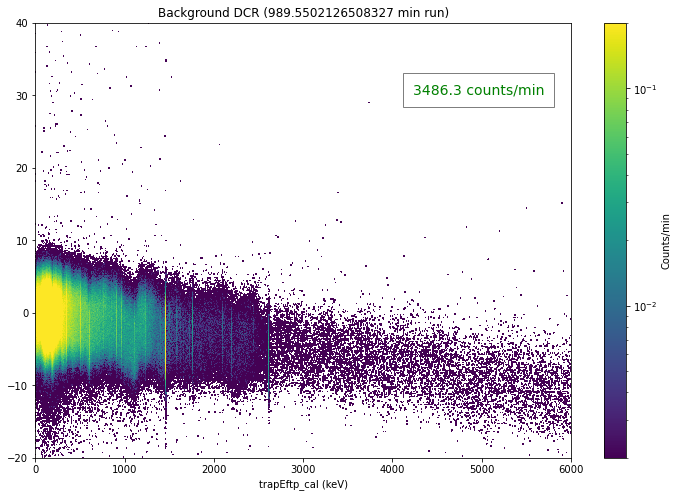

In [63]:
#bkg DCR

dlo, dhi, dpb = -20., 40, 0.1
elo, ehi, epb = 0, 6000, 5
        

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

bkg_dcr_hist, xedges, yedges = np.histogram2d(bkg_df_cut[etype], bkg_df_cut['dcr_new'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))

X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

bkg_dcr_hist_norm = np.divide(bkg_dcr_hist, (bkg_rt_min))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

ax.text(0.95, 0.83, f'{np.sum(bkg_dcr_hist_norm):.1f} counts/min', verticalalignment='bottom',
                    horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})


pcm1 = plt.pcolormesh(X, Y, bkg_dcr_hist_norm, norm=LogNorm(0.002, 0.2))

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background DCR ({bkg_rt_min} min run)')

CB = plt.colorbar(pcm1)
CB.set_label('Counts/min')

plt.show()

<ipython-input-64-7f5e17a972b6>:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(X, Y, alpha_dcr_hist_norm, norm=LogNorm(0.002, 0.2))


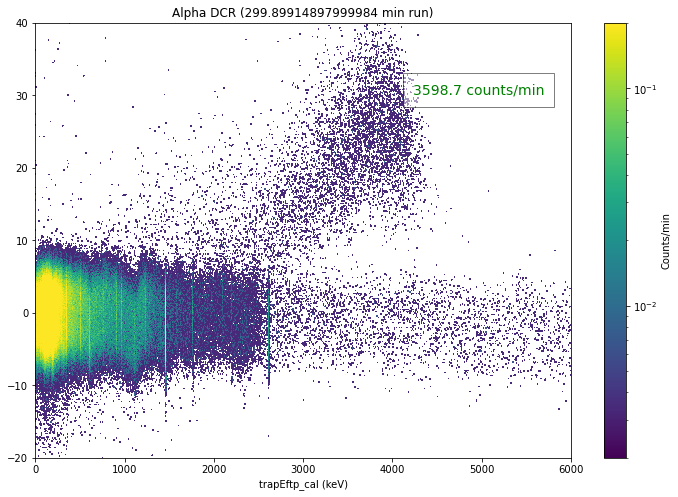

In [64]:
#Alpha DCR

dlo, dhi, dpb = -20., 40, 0.1
elo, ehi, epb = 0, 6000, 5
        

nbx = int((ehi-elo)/epb)
nby = int((dhi-dlo)/dpb)

alpha_dcr_hist, xedges, yedges = np.histogram2d(alpha_df_cut[etype], alpha_df_cut['dcr_new'], bins=[nbx, nby], range=([elo, ehi], [dlo, dhi]))

X, Y = np.mgrid[elo:ehi:nbx*1j, dlo:dhi:nby*1j]

alpha_dcr_hist_norm = np.divide(alpha_dcr_hist, (alpha_rt_min))

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

ax.text(0.95, 0.83, f'{np.sum(alpha_dcr_hist_norm):.1f} counts/min', verticalalignment='bottom',
                    horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

pcm1 = plt.pcolormesh(X, Y, alpha_dcr_hist_norm, norm=LogNorm(0.002, 0.2))


plt.xlabel(f'{etype} (keV)')
plt.title(f'Alpha DCR ({alpha_rt_min} min run)')

CB = plt.colorbar(pcm1)
CB.set_label('Counts/min')

plt.show()

Create BG subtracted DCR hists

In [58]:
dcr_backgroundSub = (bkg_dcr_hist_norm - alpha_dcr_hist_norm)
dcr_backgroundSub_1 = (alpha_dcr_hist_norm - bkg_dcr_hist_norm)

clipped = dcr_backgroundSub_1.clip(0)
print(np.min(dcr_backgroundSub_1))
print(np.sum(alpha_dcr_hist_norm))
print(np.sum(alpha_dcr_hist_norm) - np.sum(bkg_dcr_hist_norm))
# print(np.sum(dcr_backgroundSub_1))

-0.24743794206012376
3598.709778506155
112.42585284416964


In [59]:
print(np.sum(bkg_dcr_hist_norm) - np.sum(dcr_backgroundSub))
print(np.min(dcr_backgroundSub))

3598.7097785061537
-0.9661299755113912


<ipython-input-60-43ef436622ad>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, Y, dcr_backgroundSub, norm=LogNorm(0.002, 0.2))


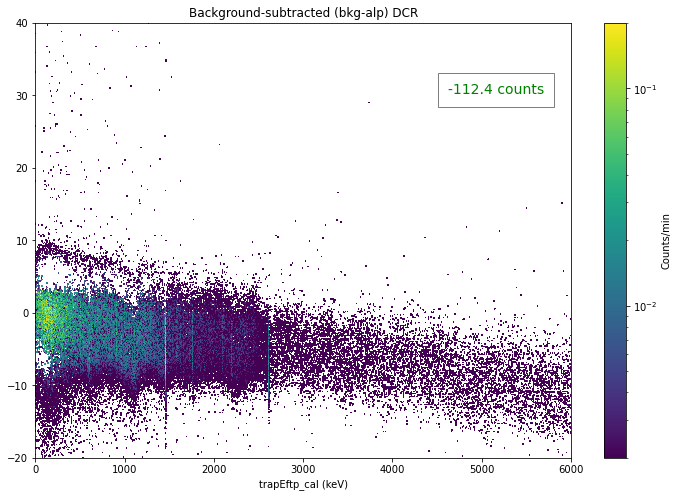

In [60]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()


pcm2 = plt.pcolormesh(X, Y, dcr_backgroundSub, norm=LogNorm(0.002, 0.2))

ax.text(0.95, 0.83, f'{np.sum(dcr_backgroundSub):.1f} counts', verticalalignment='bottom',
                    horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background-subtracted (bkg-alp) DCR')


CB = plt.colorbar(pcm2)
CB.set_label('Counts/min')

plt.show()

<ipython-input-61-73437141b403>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm2 = plt.pcolormesh(X, Y, dcr_backgroundSub_1, norm=LogNorm(0.002, 0.2))


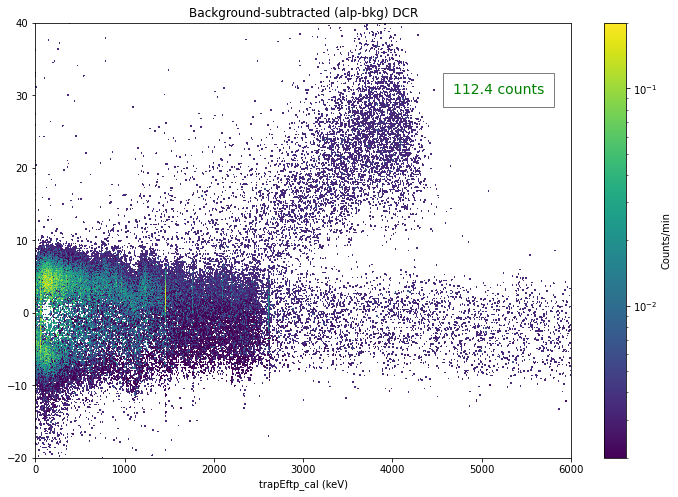

In [61]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

pcm2 = plt.pcolormesh(X, Y, dcr_backgroundSub_1, norm=LogNorm(0.002, 0.2))

plt.xlabel(f'{etype} (keV)')
plt.title(f'Background-subtracted (alp-bkg) DCR')

# leg = plt.legend(f'{np.sum(dcr_backgroundSub_1)} counts', loc= 'upper right')
# leg.show()
ax.text(0.95, 0.83, f'{np.sum(dcr_backgroundSub_1):.1f} counts', verticalalignment='bottom',
                    horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

CB = plt.colorbar(pcm2)
CB.set_label('Counts/min')

plt.show()

In [41]:
# with open('test3d_save_hist.pkl', 'wb') as f:
#     pl.dump(energy_aoe_dcr_hist, f)